In [35]:
import os
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm

In [43]:
pw = os.getcwd()
terminus_data_path = pw+"/../data/terminus_data/"        # folder where all the data for terminus position and terminus sections is stored
veloc_data_path    = pw+"/../data/velocity/"
weather_data_path  = pw+"/../data/weather/"
mooring_data_path  = pw+"/../data/mooring/"

In [186]:
# load datasets
df_veloc      = pd.read_csv(veloc_data_path+"velocity_by_section.csv")
df_terminus   = pd.read_csv(terminus_data_path+"retreat_by_section.csv")
df_weather    = pd.read_csv(weather_data_path+"compiled_weather_data_PDDs.csv")
df_mooring    = pd.read_csv(mooring_data_path+"GAK_smooth.csv")
# bring time vectors into right format
t                  = [dt.datetime.strptime(day, "%Y-%m-%d").date() for day in df_terminus.Date]
df_veloc.Date      = pd.to_datetime(df_veloc.Date)
df_terminus.Date   = pd.to_datetime(df_terminus.Date)
df_mooring.Date    = pd.to_datetime(df_mooring.Date)
df_weather["Date"] = pd.to_datetime(df_weather.iloc[:,0])  # already has a sample each day

In [187]:
def equal_period(df_long, df_short):
    idx = np.where((df_long["Date"] >= np.min(df_short["Date"])) & (df_long["Date"] <= np.max(df_short["Date"])))[0]
    return df_long.iloc[idx,:]

df_weather_short = equal_period(df_weather, df_veloc)
df_weather_short   = df_weather_short.filter(items=["Date", "AirTempC_Yakutat", "Precip_Yakutat", "PDD_Yakutat", "AirTempC_Haenke1"])

df_mooring_short = equal_period(df_mooring, df_veloc)

In [188]:
# resample/interpolate time series to daily values (so they can later be averaged over the year more easily) and average over section
df_all  = pd.DataFrame()
for (df, nam) in zip([df_veloc, df_terminus, df_weather_short, df_mooring.iloc[:,0:4]], ["velocity", "terminus", "", ""]):
    df = df.resample("d", on="Date").mean().interpolate()
    if df_all.empty:
        df_all["Date"] = pd.to_datetime(df.index)  # df.index
    if (nam == "velocity") or (nam == "terminus"):
        df_all[nam] = df.mean(axis=1).values
    else:
        df_all = df.merge(df_all, how="inner", on="Date")

In [149]:
df_save = df_all.rename(columns={"terminus":"terminus_advance_m", "velocity":"surface_speed_m_per_yr", "Temperature [deg C] @ 25m":"OceanTemp@25m_degC", "Temperature [deg C] @ 50m":"OceanTemp@50m_degC", "Temperature [deg C] @ 100m":"OceanTemp@100m_degC"})
df_save.to_csv("terminus_speed_weather_ocean.csv", index=False)

In [189]:
# make sure the end of the time series stops at the day of the year it starts (otherwise there are jumps in computing means over different years if days in e.g. January have less samples than in May)
end_year      = df_all.Date.iloc[-1].year
start_date    = df_all.Date.iloc[0].date()
end_date      = start_date.replace(year=end_year)
id_full_years = np.where(df_all.Date < pd.Timestamp(end_date) - pd.Timedelta(days=1))               # removing last day as the last year 2020 happens to be a leap day, makes sure there is the same amount of days in all of the years
df_full_years = df_all.iloc[id_full_years[0],:]
df_full_years

,Date,Temperature [deg C] @ 25m,Temperature [deg C] @ 50m,Temperature [deg C] @ 100m,AirTempC_Yakutat,Precip_Yakutat,PDD_Yakutat,AirTempC_Haenke1,velocity,terminus
0,2017-04-12,4.681443,4.399093,4.542344,5.765234,0.001963,5.765234,5.468817,2187.771366,173.212460
1,2017-04-13,4.726428,4.441599,4.560987,5.951945,0.001893,5.951945,9.278022,2194.505516,172.028597
2,2017-04-14,4.771240,4.483915,4.579745,6.138656,0.001824,6.138656,8.115217,2208.453016,171.839343
3,2017-04-15,4.815879,4.526030,4.598621,6.325367,0.001755,6.325367,4.796809,2222.400515,171.650089
4,2017-04-16,4.860341,4.567942,4.617620,6.512078,0.001686,6.512078,3.600000,2236.348015,171.460835
...,...,...,...,...,...,...,...,...,...,...
1090,2020-04-06,4.271781,4.318969,4.621356,1.583178,0.001778,1.583178,0.977083,1963.884725,117.302915
1091,2020-04-07,4.287536,4.332032,4.628699,-0.935093,0.001524,0.000000,-0.610417,1962.141174,116.711920
1092,2020-04-08,4.305182,4.345452,4.636908,1.727566,0.008382,1.727566,-0.003125,1969.128689,116.334838
1093,2020-04-09,4.324796,4.359252,4.646167,2.144985,0.009398,2.144985,1.723958,1976.116203,115.957755


In [190]:
def unique(x):
    return list(set(x))

# average over the year
tind    =  [di.timetuple().tm_yday for di in df_full_years["Date"] ]   # day of the year
ti_start_date = start_date.timetuple().tm_yday -1
strt_date = dt.date(start_date.year, 1, 1)
df_avyr = pd.DataFrame()
for col in df_full_years:
    if col == "Date":
        continue
    vls = []
    for dd in range(np.min(tind), np.max(tind)+1):
        val = np.mean(df_full_years[col][np.where(np.array(tind) == dd)[0]])
        vls.append(val)
    if df_avyr.empty:
        ds = []
        for doy in np.sort(unique(tind)):
            if doy <= ti_start_date:
                ds.append(strt_date.replace(year=strt_date.year+1)  + dt.timedelta(days=int(doy) - 1))
            else:
                ds.append(strt_date + dt.timedelta(days=int(doy) - 1))
        df_avyr["Date"] = ds
    df_avyr[col] = vls
df_avyr.sort_values(by="Date", inplace=True)
df_avyr.Date = pd.to_datetime(df_avyr.Date)   # otherwise Date is not in the correct format for .resample

In [191]:
# use lowess filter to smooth temperatue time series, easier on day index rather than datetime format
t0 = pd.Timestamp(dt.datetime.strptime("2017-01-01", "%Y-%m-%d").date())
t_index_data   = np.zeros(len(df_avyr.Date), dtype=int)
# ddd = [dt.datetime.strptime(d, format).date() for d in df_avyr["Date"]]
for (i, da) in enumerate(df_avyr.Date):
    deltat = da - t0
    t_index_data[i] = deltat.days
lowess = sm.nonparametric.lowess

df_smooth = pd.DataFrame({"Date" : df_avyr.Date})
z = lowess(df_avyr["AirTempC_Yakutat"], t_index_data, frac=1/7, xvals=t_index_data)
df_smooth["AirTempC_Yakutat"] = z
z = lowess(df_avyr["AirTempC_Haenke1"], t_index_data, frac=1/7, xvals=t_index_data)
df_smooth["AirTempC_Haenke1"] = z

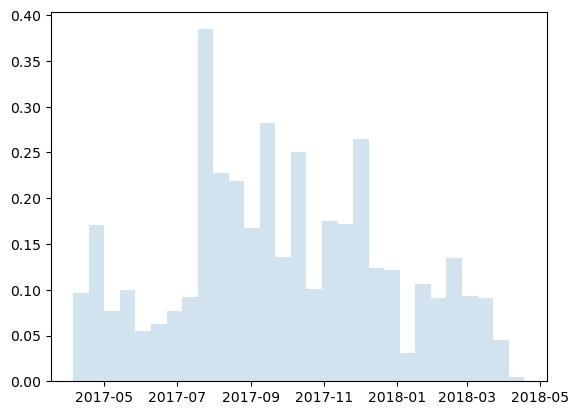

In [192]:
# resample precipitation data
dt_resample = 13
df_sum = df_avyr.resample(str(dt_resample)+"d", on="Date").sum().interpolate()
ax = plt.subplot(111)
ax.bar(df_sum.index, df_sum.Precip_Yakutat, width=dt.timedelta(days=dt_resample), alpha=0.2, linewidth=0)
ax.xaxis_date()

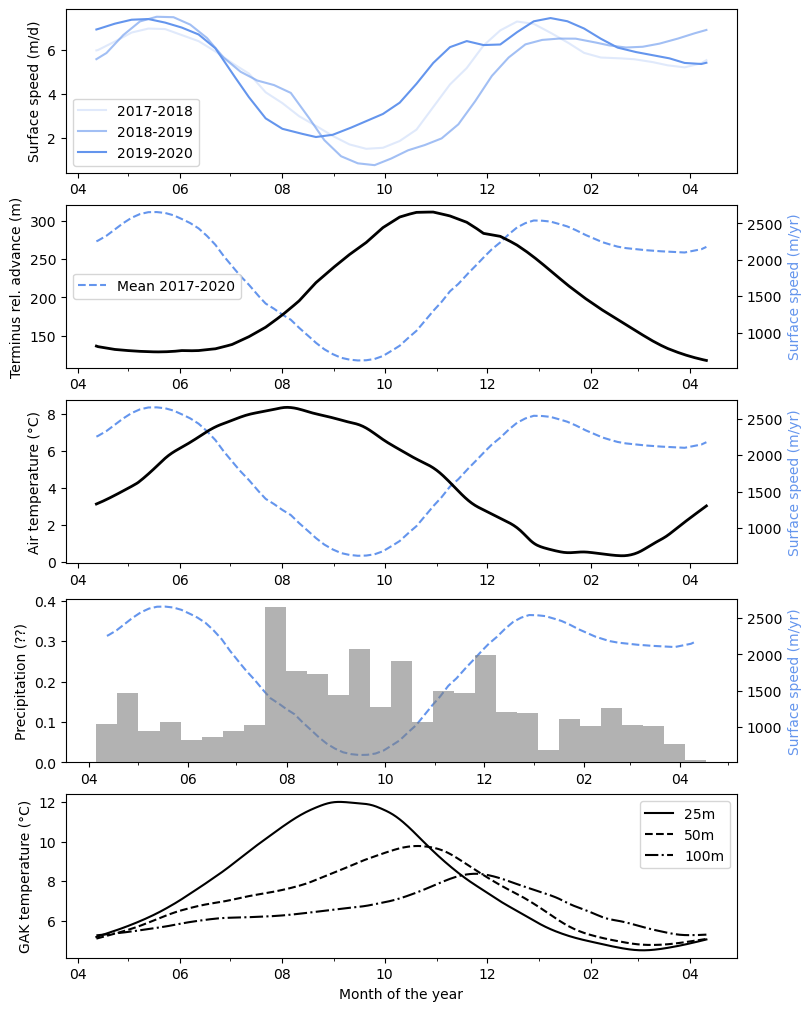

In [193]:
def format_ax(ax, plot_vel=True, draw_legend=False):
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[2,4,6,8,10,12]))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
    if plot_vel:
        secax = ax.twinx()
        secax.plot(df_avyr["Date"], df_avyr["velocity"], color="cornflowerblue", linestyle="--", label="Mean 2017-2020")
        secax.set_ylabel("Surface speed (m/yr)", color="cornflowerblue")
        ax.set_zorder(secax.get_zorder()+1)
        ax.set_frame_on(False)                      # see https://matplotlib.org/stable/gallery/text_labels_and_annotations/date.html
        if draw_legend:
            secax.legend(loc="center left")

# can replace df_avyr by df_all to only average over sections and not year
fig, ax = plt.subplots(5,1, layout='constrained', figsize=(8,10))

# velocity
i = 0
alphas = [0.2, 0.6, 1.0]
for ii in range(1, 4):
    yr0 = pd.Timestamp(start_date) + pd.Timedelta(days=365*(ii-1))
    id_yr = np.where((df_full_years.Date >= yr0) & (df_full_years.Date < pd.Timestamp(start_date) + pd.Timedelta(days=365*ii)))[0]
    ax[i].plot(df_avyr.Date, df_full_years["velocity"][id_yr] / 365, color="cornflowerblue", alpha=alphas[ii-1], label=str(yr0.year)+"-"+str(yr0.year+1))
    ax[i].set_ylabel("Surface speed (m/d)")
    ax[i].legend()
format_ax(ax[i], plot_vel=False)

# Terminus position
i = 1
ax[i].plot(df_avyr["Date"], df_avyr.terminus, color="black", lw=2); ax[i].set_ylabel("Terminus rel. advance (m)")
format_ax(ax[i], draw_legend=True)

# Air temperature
i = 2
ax[i].plot(df_smooth["Date"], df_smooth.AirTempC_Haenke1, color="black", lw=2); ax[i].set_ylabel("Air temperature (°C)")
format_ax(ax[i])

# Precipitation
i = 3
ax[i].bar(df_sum.index, df_sum.Precip_Yakutat, width=dt.timedelta(days=dt_resample), color="grey", alpha=0.6, linewidth=0); ax[i].set_ylabel("Precipitation (??)")
format_ax(ax[i])

# GAK temperatures
i = -1
stls = ["-", "--", "-.", "-.", "."]
for (n,col) in enumerate(df_all.filter(like="Temperature [deg C] @", axis=1)):
    ax[i].plot(df_avyr["Date"], df_avyr[col], stls[n], label=col.split(" ")[-1], color="black"); ax[i].set_ylabel("GAK temperature (°C)")
    ax[i].legend()
    ax[i].set_xlabel("Month of the year")
format_ax(ax[i], False)

fig.savefig("four-panel-yearly.jpg")